In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import os
import re




In [4]:
current_dir = os.getcwd()


#just a quick verif to check whether the file exist in the current directory and whether the current directory itself exist
if len(current_dir) != 0 and re.search(r"^C:\\",current_dir):
    print("Directory exist\n")
else:
    raise ValueError("Directory empty \n")

print(current_dir)

found = False
for i in os.listdir(current_dir):
    if i == "listings.csv":
        print("CSV file existing\n")
        found = True
        data = pd.read_csv("listings.csv")
        break

if not found:
    print("csv missing\n")
    exit(-1)

Directory exist

C:\Users\Yuan Shao\Desktop\multimodal_pro
CSV file existing



Just merely meant to tinker with the os lib

In [5]:
print(data.head(15),end="\n")
#print(data.columns,end="\n")
col = data.columns
filt = col.str.contains(r"review",regex=True)
data_filt = data.loc[:,filt].any(axis=1)
print(data.loc[data_filt].head(3),end="\n")

#let us find out about the host
print(data.columns)


         id                           listing_url       scrape_id  \
0   2719440  https://www.airbnb.com/rooms/2719440  20250912034503   
1   2721397  https://www.airbnb.com/rooms/2721397  20250912034503   
2   2726092  https://www.airbnb.com/rooms/2726092  20250912034503   
3   2726327  https://www.airbnb.com/rooms/2726327  20250912034503   
4   2727929  https://www.airbnb.com/rooms/2727929  20250912034503   
5   2729247  https://www.airbnb.com/rooms/2729247  20250912034503   
6   2732500  https://www.airbnb.com/rooms/2732500  20250912034503   
7   2733196  https://www.airbnb.com/rooms/2733196  20250912034503   
8   2735222  https://www.airbnb.com/rooms/2735222  20250912034503   
9   2738129  https://www.airbnb.com/rooms/2738129  20250912034503   
10  2808483  https://www.airbnb.com/rooms/2808483  20250912034503   
11  2808778  https://www.airbnb.com/rooms/2808778  20250912034503   
12  2810629  https://www.airbnb.com/rooms/2810629  20250912034503   
13  2813840  https://www.airbnb.co

Here we have 2 kind of data, structed (quantitative/qualitative) and unstructured(text) 

Hypothesis, we might have to resort to use models applied to numerics/categorical variables thus text mining(TF-IDF so on and so forth) 

***NOW LET US FOCUS ON THE SUPERHOST***

host_is_superhost
0.0    62568
1.0    16972
NaN     2313
Name: count, dtype: int64


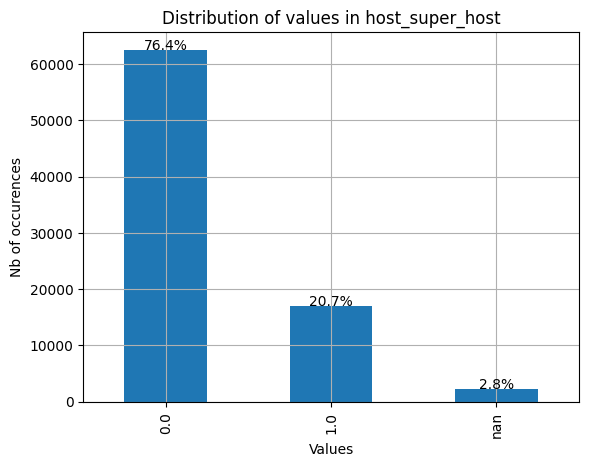

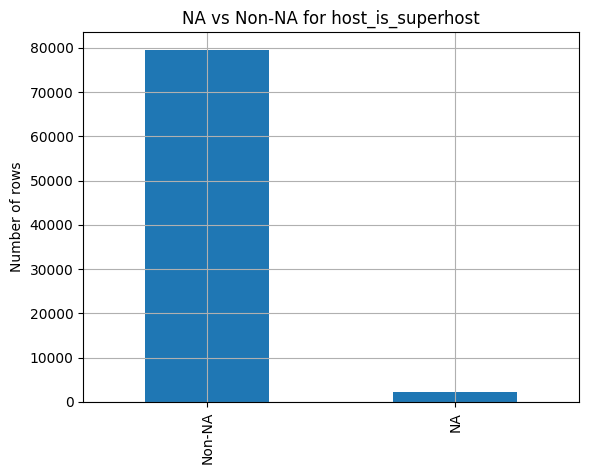

                 id     scrape_id       host_id  host_is_superhost  \
count  8.185300e+04  8.185300e+04  8.185300e+04       79540.000000   
mean   6.474769e+17  2.025091e+13  1.881639e+08           0.213377   
std    5.533184e+17  0.000000e+00  2.105173e+08           0.409694   
min    3.109000e+03  2.025091e+13  2.626000e+03           0.000000   
25%    3.124670e+07  2.025091e+13  1.932200e+07           0.000000   
50%    8.417510e+17  2.025091e+13  7.426650e+07           0.000000   
75%    1.130166e+18  2.025091e+13  3.445411e+08           0.000000   
max    1.482029e+18  2.025091e+13  7.171757e+08           1.000000   

       host_listings_count  host_total_listings_count  \
count         81833.000000               81833.000000   
mean             30.160217                  39.745164   
std             116.081728                 155.466214   
min               0.000000                   0.000000   
25%               1.000000                   1.000000   
50%               1.000000 

In [6]:
data["host_is_superhost"] = data["host_is_superhost"].map({"f":0,"t":1})

distrib = data["host_is_superhost"].value_counts(dropna=False)

print(distrib)

#distribution to explore and understand more
distrib.plot(kind="bar")
plt.title("Distribution of values in host_super_host")
perc = (lambda x: (x / distrib.sum())*100)

for i,v in enumerate(distrib):
    
    plt.text(i,v,f"{perc(v):.1f}%",ha="center")
plt.xlabel("Values")
plt.ylabel("Nb of occurences")
plt.grid(True)
plt.show()

na_mask = data["host_is_superhost"].isna()

na_counts = na_mask.value_counts()
na_counts.index = ["Non-NA", "NA"]
na_counts.plot(kind="bar")
plt.title("NA vs Non-NA for host_is_superhost")
plt.ylabel("Number of rows")
plt.grid(True)
plt.show()


print(data.describe())
print(f"\n{data.dtypes.value_counts()}")

#let us retrieve numerical variables
target = "host_is_superhost"

num_col = data.select_dtypes(include=["number"]).columns.tolist()
num_col = [c for c in num_col if c != target]

quali_col = data.select_dtypes(exclude=["number"]).columns.tolist()

print(data[num_col].describe().T) #Here certain values may be counted as NAN because they are not numerically formated


***We now notice that columns ids are unique and not relevant for predictions, therefore we may remove EM***

In [7]:
data.shape
#data.drop(columns=["id","scrape_id","host_id"],axis=1,inplace=True)
print("After removal\n")
data.shape

After removal



(81853, 79)

***We notice that urls are irelevant in our case, so they are to be removed as well***

In [8]:
url_list : list = [x for x in data.columns if re.search("url",x)]
print(url_list)

['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']


In [9]:
data.drop(columns=url_list,axis=1,inplace=True)

In [10]:
data.shape[1]

74

***looks like we got some metadata as well such as scraping columns and source***

In [11]:
scrap_l : list = [cl for cl in data.columns if re.search("scraped",cl) or re.search("source",cl)]
print(scrap_l)

['last_scraped', 'source', 'calendar_last_scraped']


In [12]:
data.drop(columns=scrap_l,axis=1,inplace=True)

In [13]:
data.shape

(81853, 71)

***I had an idea, I thought perhaps I should check for all columns containing NA and sort them by quantity of NAN VALUES***

In [14]:
na_ratio = data.isna().mean().sort_values(ascending=False)

In [15]:
na_ratio.head(20)

neighbourhood_group_cleansed    1.000000
estimated_revenue_l365d         1.000000
bathrooms                       1.000000
calendar_updated                1.000000
beds                            1.000000
price                           1.000000
host_neighbourhood              0.657948
host_about                      0.554042
neighbourhood                   0.516206
neighborhood_overview           0.516206
host_response_rate              0.393449
host_response_time              0.393449
host_acceptance_rate            0.319231
review_scores_value             0.219638
review_scores_checkin           0.219638
review_scores_location          0.219625
review_scores_accuracy          0.219552
review_scores_communication     0.219528
review_scores_cleanliness       0.219515
review_scores_rating            0.219418
dtype: float64

***We do have interesting informations here, as we can see somecolumns have 100% NANS values, therefore irrelevant informations for our predictions***

In [16]:
print(type(na_ratio))

<class 'pandas.core.series.Series'>


In [17]:
na_ratio = na_ratio[na_ratio > 0.8].index.tolist()
na_ratio

['neighbourhood_group_cleansed',
 'estimated_revenue_l365d',
 'bathrooms',
 'calendar_updated',
 'beds',
 'price']

***Surprised to notice that the price***

In [18]:
print(data["price"])
#Price contains no values, therefore it is a useless numerical value

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
81848   NaN
81849   NaN
81850   NaN
81851   NaN
81852   NaN
Name: price, Length: 81853, dtype: float64


In [17]:
data.drop(columns=na_ratio,axis=1,inplace=True)

In [18]:
data.shape

(81853, 65)

In [21]:
na_ratio = data.isna().mean().sort_values(ascending=False)
na_ratio

neighbourhood_group_cleansed    1.0
estimated_revenue_l365d         1.0
bathrooms                       1.0
calendar_updated                1.0
beds                            1.0
                               ... 
availability_30                 0.0
availability_60                 0.0
availability_90                 0.0
availability_365                0.0
maximum_nights                  0.0
Length: 71, dtype: float64

In [22]:
data.columns

Index(['id', 'scrape_id', 'name', 'description', 'neighborhood_overview',
       'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_36

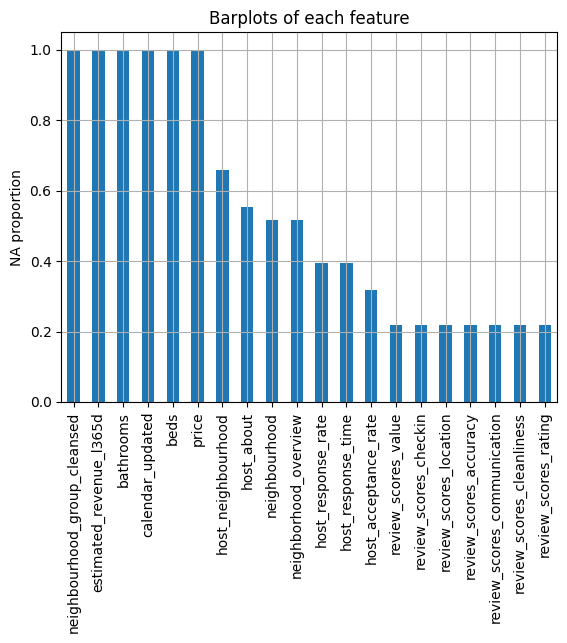

In [23]:
#Let's visualize our data
na_ratio.head(20).plot(kind="bar")
plt.ylabel("NA proportion")
plt.grid(True)
plt.title("Barplots of each feature")
plt.show()

#New Idea, ***observing numerical features to check whether we have correlations, perhaps a PCA could help us if we do see some***

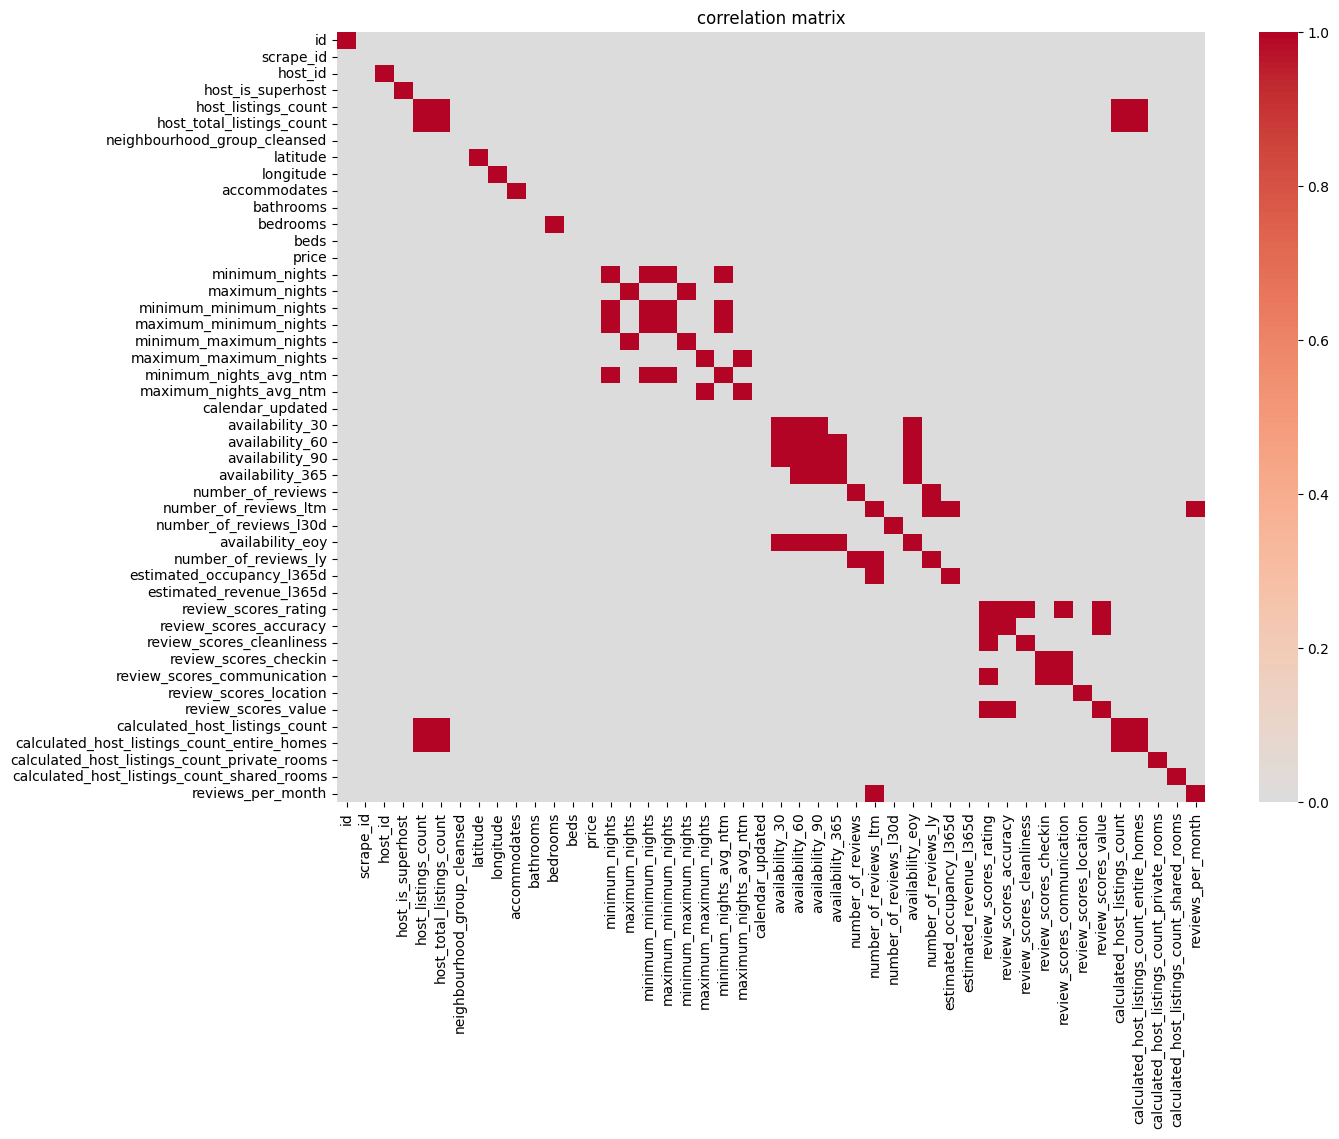

In [24]:
num = data.select_dtypes(include="number").columns
corr = data[num].corr()
strong_cor = corr > 0.7
import seaborn as sns
plt.figure(figsize=(14,10))
sns.heatmap(strong_cor,cmap="coolwarm",center=0)
plt.title("correlation matrix")
plt.show()

***The heatmap(correlation matrix) shows something interesting, several groups of variables are strongly correlated(housing availability, activity and quality)
Furthermore the rating of profesionnalism of hosts. This structure suggests the existence of commun dimmensions and colinearity between columns. Which indicates the possibility of using exploratory
techniques, such as PCA on those quantitative variables.***

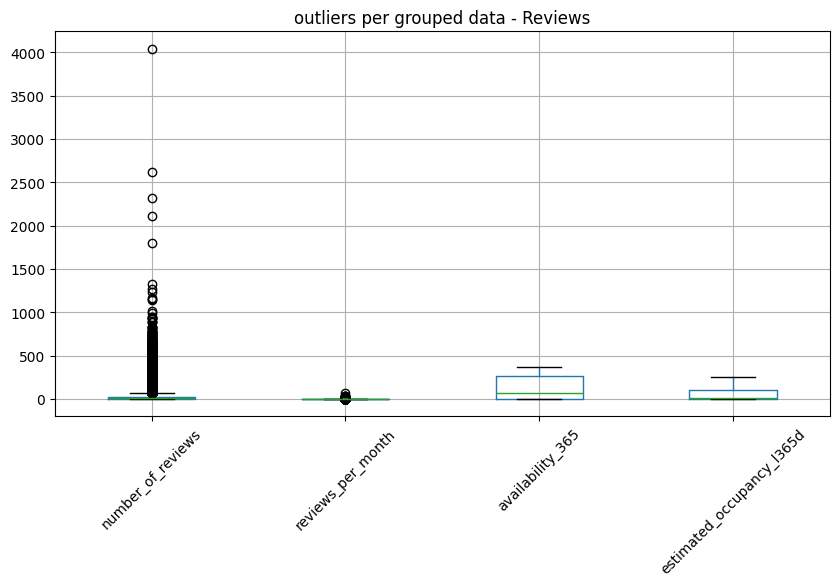

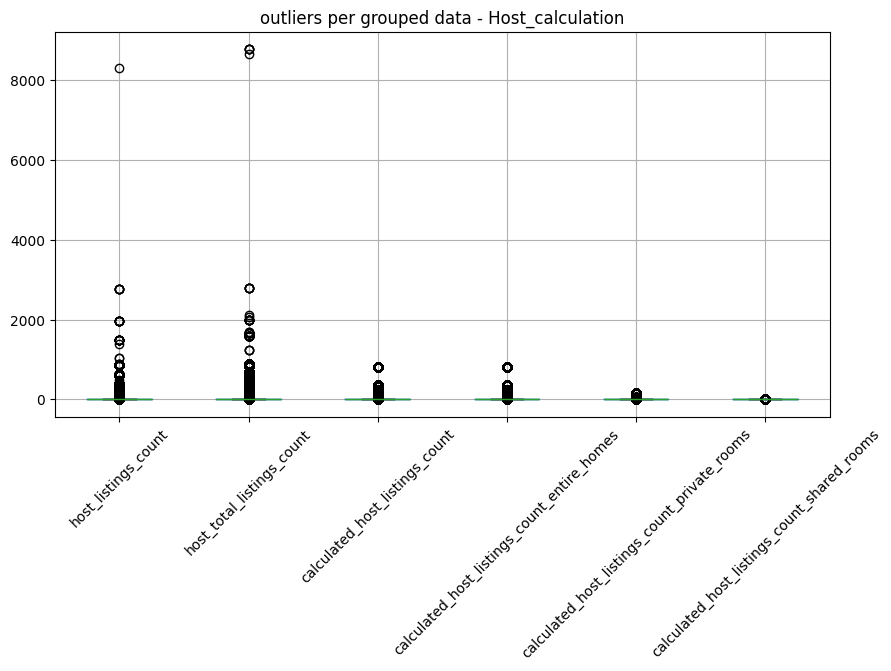

Number of NAN values in number_of_reviews

20815 outliers superior to the average

Quantiles: 0.25      1.00
0.50      7.00
0.75     28.00
0.90     69.00
0.99    293.48
Name: number_of_reviews, dtype: float64


In [25]:
#I had an idea, I shall display boxplots to understand outliers in different grouped data

activity_cols = [
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "estimated_occupancy_l365d"
]

host_cols = [
    "host_listings_count",
    "host_total_listings_count",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms"
]

group = {
    "Reviews" : activity_cols,
    "Host_calculation" : host_cols
}


for name, index in group.items():

    data[index].boxplot(figsize=(10,5),rot=45)
    plt.title(f"outliers per grouped data - {name}")
    plt.grid(True)
    plt.show()


print("Number of NAN values in number_of_reviews\n")
nb_rev_av = data["number_of_reviews"].mean()
nb = (data["number_of_reviews"] > nb_rev_av).sum()
print(f"{nb} outliers superior to the average\n")
print(f"Quantiles: {data["number_of_reviews"].quantile([0.25, 0.5, 0.75, 0.9, 0.99])}")


***Calculating the quantiles we observe interesting scenarios, around 0.01% of housing receive 293 reviews but 50% of theme receive under 7 reviews***

***IMPORTANT TO KEEP IN MIND***

1- Several numerical variables can be grouped into a family corresponding to housing,quality,availability so on and so forth.

2- Distributions are strongly asymetric

3- Several NAN variables in columns are important informations to take into account, they reflect the abscence of history or activity for certain hosts. Therefore still relevant

4- Last but not least, data found in text, indicate communication and relevant informations regarding the quality of the host

***Let us explore comments***


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000001AE9B1D7920> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

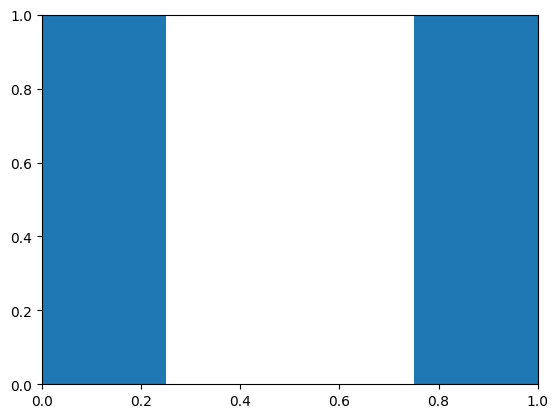

In [26]:
text_present = (data["description"].str.len() > 0)

distrib = text_present.value_counts(normalize=True) * 100

distrib.plot(kind="bar")
plt.title("Présence de description (%)")
plt.ylabel("Pourcentage")
plt.grid(axis="y", alpha=0.3)
plt.show()


***Let us operate on the comments and fill the NA with empty text***

In [27]:
data["description"] = data["description"].fillna("")
emp_ratio = (data["description"].str.len() == 0).mean()
print(f"Ratio of empty comments{emp_ratio}\n")

Ratio of empty comments0.03314478394194471



In [29]:
#let us count the number of words
data["length_of_words"] = data["description"].str.split().apply(len)
data["length_of_words"].describe()
data.groupby("host_is_superhost")["length_of_words"].mean()

host_is_superhost
0.0    55.436629
1.0    60.919632
Name: length_of_words, dtype: float64

***TRULY interesting results !***
It seems that the proportion of words for good/bad host is relatively the same, but again some comments or missing but host_is_supperhost is missing a lot of values

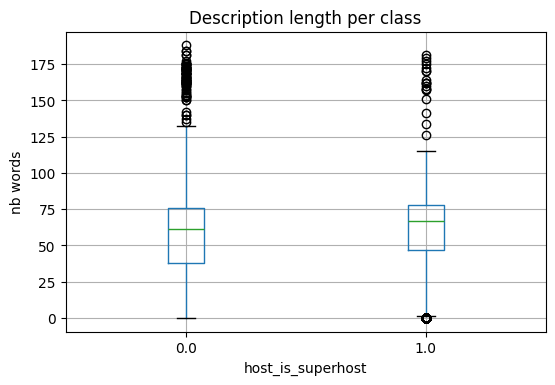

In [30]:
data.boxplot(column="length_of_words",by="host_is_superhost",figsize=(6,4))
plt.title("Description length per class")
plt.suptitle("")
plt.ylabel("nb words")
plt.grid(True)
plt.show()

***A LOT OF OUTLIERS and the median between good and bad host are almost the same, but the mean of super host seems higher, displaying an effort of the user to speak***

In [32]:
print("for superhost ")
print(data.loc[data["host_is_superhost"] == 1, "description"].head(2))

print("\n for non superhost")
print(data.loc[data["host_is_superhost"] == 0, "description"].head(2))


for superhost 
1    In the heart of historical Paris le Marais, gr...
5    Experience luxury on the 6th floor with elevat...
Name: description, dtype: object

 for non superhost
0    This beautiful apartment is very well located ...
2    A stone's throw from Parc Monceau and the Arc ...
Name: description, dtype: object


***3.2 INTRODUCTION***
We now have a clear understanding of what to do with our data, distinct unimodels for tabular data text(TF-IDF), and pre treatmen(normalization,missing values balancing, and hot encoding of categorical variables)
